# pvlib PV Example
This notebook demonstrates how to use the PV generation method that is based on pvlib to simulate the PV generation for multiple setups.

## Imports
Import required libraries and set visualization defaults.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd

from entise.constants import SEP, Types
from entise.constants import Columns as C
from entise.core.generator import Generator as TSGen

%matplotlib inline

## Load Data
We load the PV parameters from `objects.csv` and simulation data from the `data` folder.

In [2]:
cwd = '.'  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, 'objects.csv'))
data = {}
common_data_folder = "../common_data"
for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, common_data_folder, file)), parse_dates=True)
data_folder = 'data'
for file in os.listdir(os.path.join(cwd, data_folder)):
    if file.endswith('.csv'):
        name = file.split('.')[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, data_folder, file)), parse_dates=True)
print('Loaded data keys:', list(data.keys()))

Loaded data keys: ['weather']


## Instantiate and Configure Model
Initialize the time series generator and add the objects.

In [3]:
gen = TSGen()
gen.add_objects(objects)

## Run the Simulation
Generate sequential PV generation time series for each object.

In [4]:
summary, df = gen.generate(data, workers=1)

100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


## Results Summary
Below is a summary of the annual electricity generation, maximum generation and the full load hours of each system.

In [5]:
print("Summary:")
summary_kwh = summary
summary_kwh[f'{Types.PV}{SEP}{C.GENERATION}'] /= 1000
summary_kwh.rename(columns=lambda x: x.replace('[Wh]', '[kWh]'), inplace=True)
summary_kwh = summary_kwh.round(0).astype(int)
print(summary_kwh)

Summary:
          pv:generation[kWh]  pv:maximum_generation[W]  pv:full_load_hours[h]
367791                  7629                      5776                   1075
31991680                2752                      2519                    949
31991682                4459                      3177                   1351
31991685                 949                       786                   1187
31991686                8472                      6344                   1177
31991688               23050                     17373                   1226
31991690                   1                         1                   1108
31991691                5844                      4623                    680


## Visualization of Results
Analyze PV generation from various angles.

In [6]:
# Preparation
# Convert index to datetime for all time series
for obj_id in df:
    df[obj_id][Types.PV].index = pd.to_datetime(df[obj_id][Types.PV].index)

# Get azimuth and tilt values from objects dataframe
system_configs = {}
for _, row in objects.iterrows():
    obj_id = row['id']
    if obj_id in df:
        azimuth = row['azimuth[degree]'] if not pd.isna(row['azimuth[degree]']) else 0
        tilt = row['tilt[degree]'] if not pd.isna(row['tilt[degree]']) else 0
        power = row['power[W]'] if not pd.isna(row['power[W]']) else 1
        system_configs[obj_id] = {
            'azimuth': azimuth,
            'tilt': tilt,
            'power': power
        }

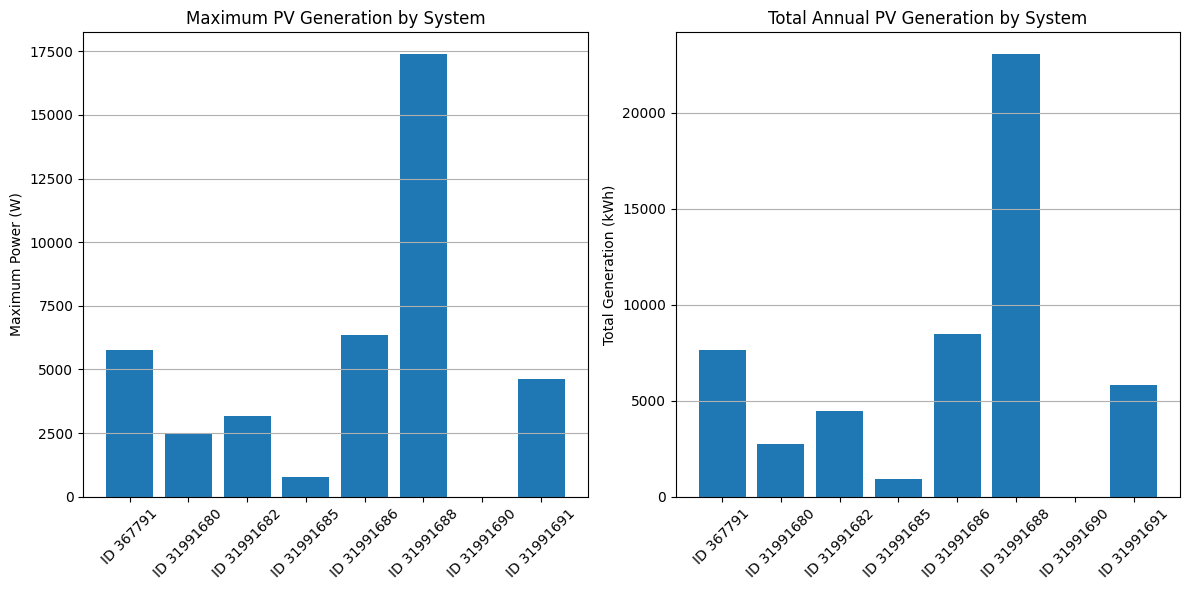

In [7]:
# Figure 1: Comparative analysis between different PV systems
# Get the maximum generation for each system
max_gen = {}
total_gen = {}
for obj_id in df:
    # Extract scalar value from Series
    max_value = df[obj_id][Types.PV].max()
    if hasattr(max_value, 'iloc'):
        max_value = max_value.iloc[0]
    max_gen[obj_id] = max_value

    # Extract scalar value from Series
    total_value = df[obj_id][Types.PV].sum() / 1000  # Convert to kWh
    if hasattr(total_value, 'iloc'):
        total_value = total_value.iloc[0]
    total_gen[obj_id] = total_value

# Create a bar chart for maximum generation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(max_gen)), list(max_gen.values()))
plt.xticks(range(len(max_gen)), [f'ID {id}' for id in max_gen.keys()], rotation=45)
plt.title('Maximum PV Generation by System')
plt.ylabel('Maximum Power (W)')
plt.grid(axis='y')

# Create a bar chart for total generation
plt.subplot(1, 2, 2)
plt.bar(range(len(total_gen)), list(total_gen.values()))
plt.xticks(range(len(total_gen)), [f'ID {id}' for id in total_gen.keys()], rotation=45)
plt.title('Total Annual PV Generation by System')
plt.ylabel('Total Generation (kWh)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

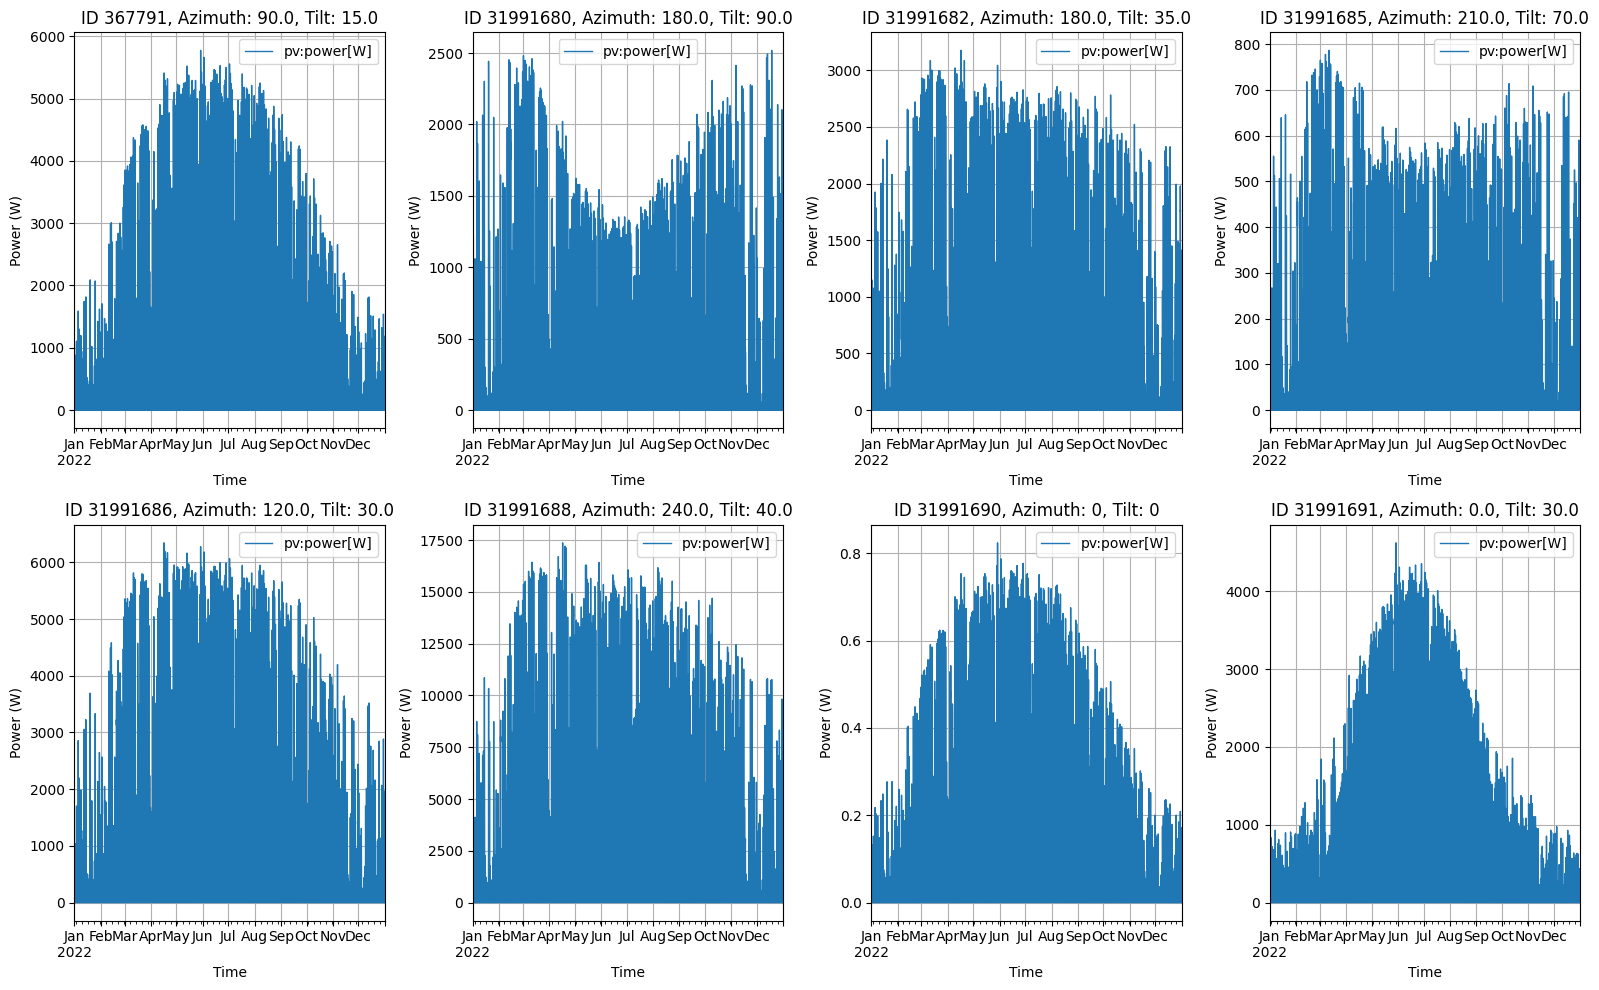

In [8]:
# Figure 2: Year timeseries visualization for all systems
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# For each PV system, create a separate subplot
for i, obj_id in enumerate(df):
    # Get azimuth and tilt values for the title
    azimuth = system_configs[obj_id]['azimuth'] if obj_id in system_configs else 0
    tilt = system_configs[obj_id]['tilt'] if obj_id in system_configs else 0

    # Plot the time series
    df[obj_id][Types.PV].plot(ax=axes[i], color='#1f77b4', linewidth=1)
    axes[i].set_title(f'ID {obj_id}, Azimuth: {azimuth}, Tilt: {tilt}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Power (W)')
    axes[i].grid(True)

plt.tight_layout()
plt.show()


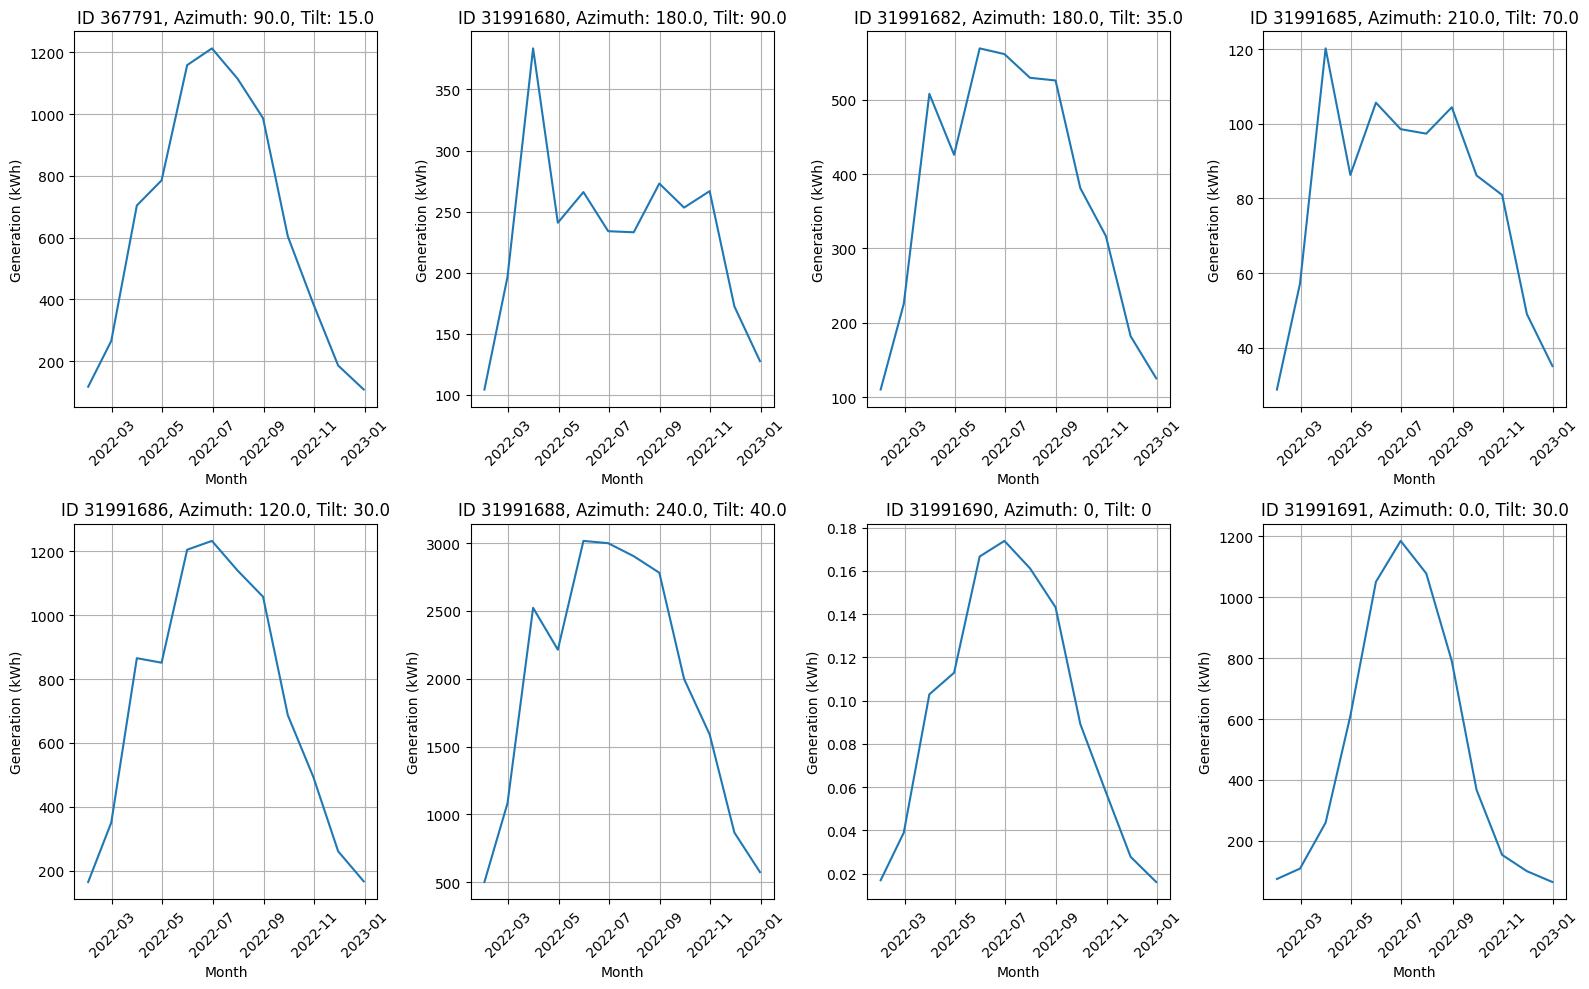

In [9]:
# Figure 3: Monthly generation analysis
# Create a figure with 8 subfigures (2x4 grid)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
monthly_data = {}

# For each PV system, create a separate subplot
for i, obj_id in enumerate(df):
    ts = df[obj_id][Types.PV]
    # Resample to monthly sums
    monthly = ts.resample('M').sum()
    monthly_data[obj_id] = monthly

    # Get azimuth and tilt values for the title
    azimuth = system_configs[obj_id]['azimuth'] if obj_id in system_configs else 0
    tilt = system_configs[obj_id]['tilt'] if obj_id in system_configs else 0

    # Plot on the corresponding subplot
    axes[i].plot(monthly.index, monthly.values / 1000)
    axes[i].set_title(f'ID {obj_id}, Azimuth: {azimuth}, Tilt: {tilt}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Generation (kWh)')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

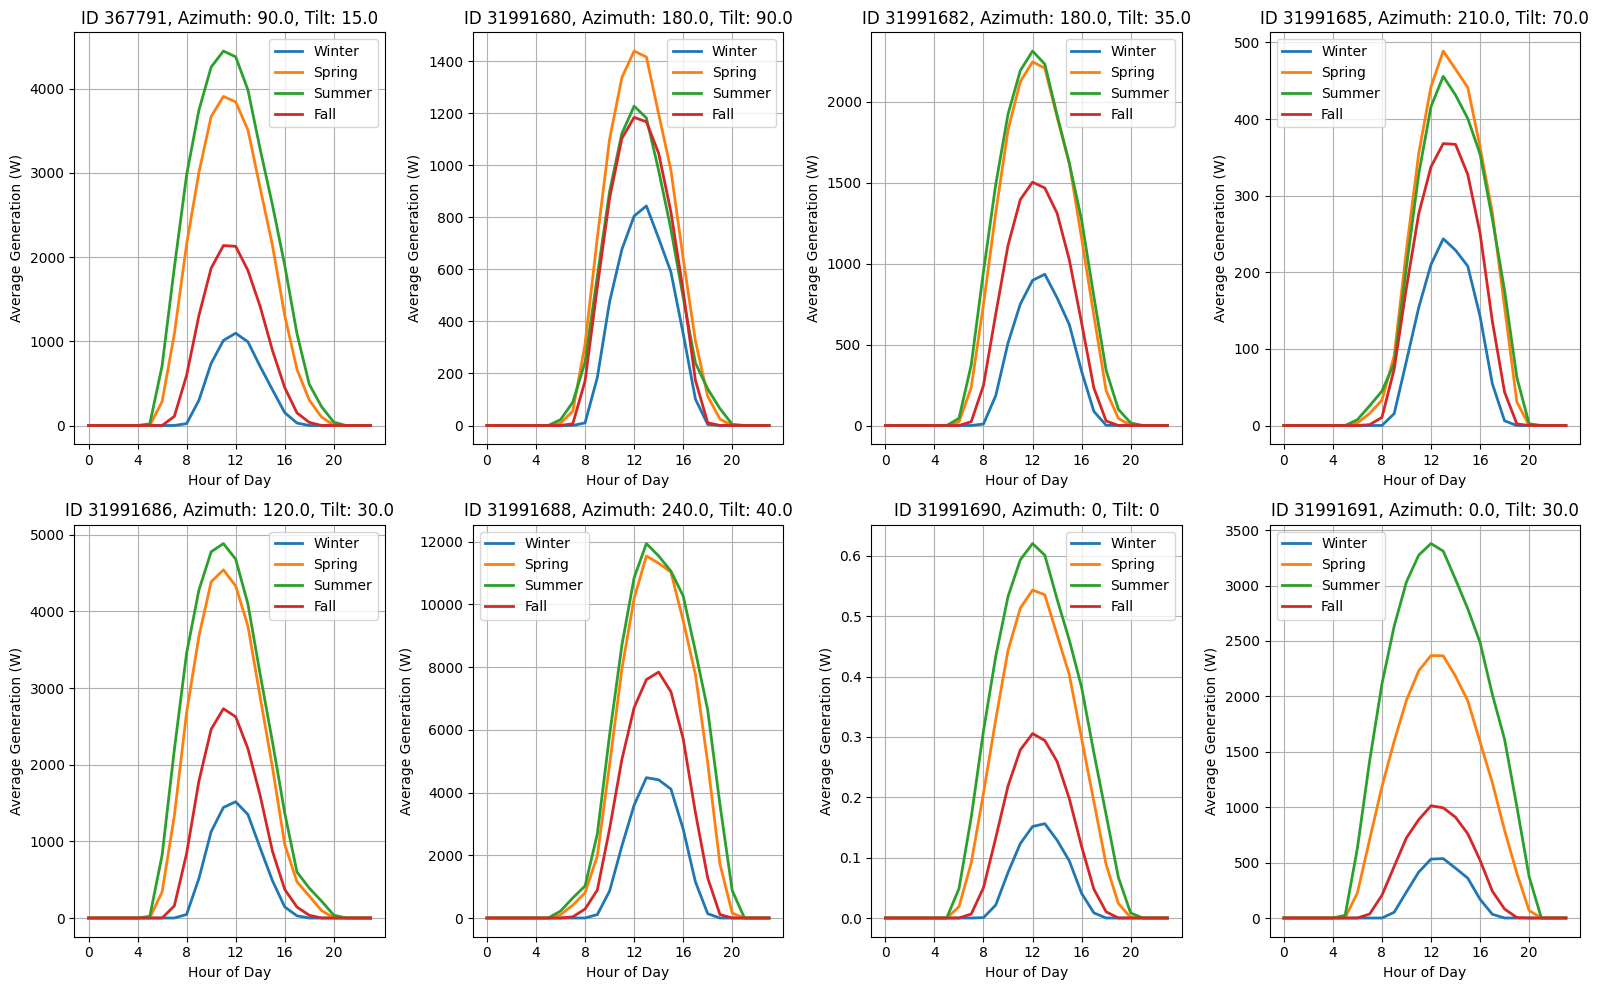

In [10]:
# Figure 4: Seasonal daily profile analysis
# Define seasons
seasons = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Fall': [9, 10, 11]
}

# Create a figure with 8 subfigures (2x4 grid)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# For each PV system, create a separate subplot
for i, obj_id in enumerate(df):
    ts = df[obj_id][Types.PV]

    # Get azimuth and tilt values for the title
    azimuth = system_configs[obj_id]['azimuth'] if obj_id in system_configs else 0
    tilt = system_configs[obj_id]['tilt'] if obj_id in system_configs else 0

    # Plot each season on the same subplot
    for season_name, months in seasons.items():
        # Filter data for the season
        season_data = ts[ts.index.month.isin(months)]
        # Create average daily profile
        daily_profile = season_data.groupby(season_data.index.hour).mean()
        axes[i].plot(daily_profile.index, daily_profile.values, label=season_name, linewidth=2)

    axes[i].set_title(f'ID {obj_id}, Azimuth: {azimuth}, Tilt: {tilt}')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Average Generation (W)')
    axes[i].legend()
    axes[i].grid(True)
    axes[i].set_xticks(range(0, 24, 4))  # Show fewer ticks for readability

plt.tight_layout()
plt.show()

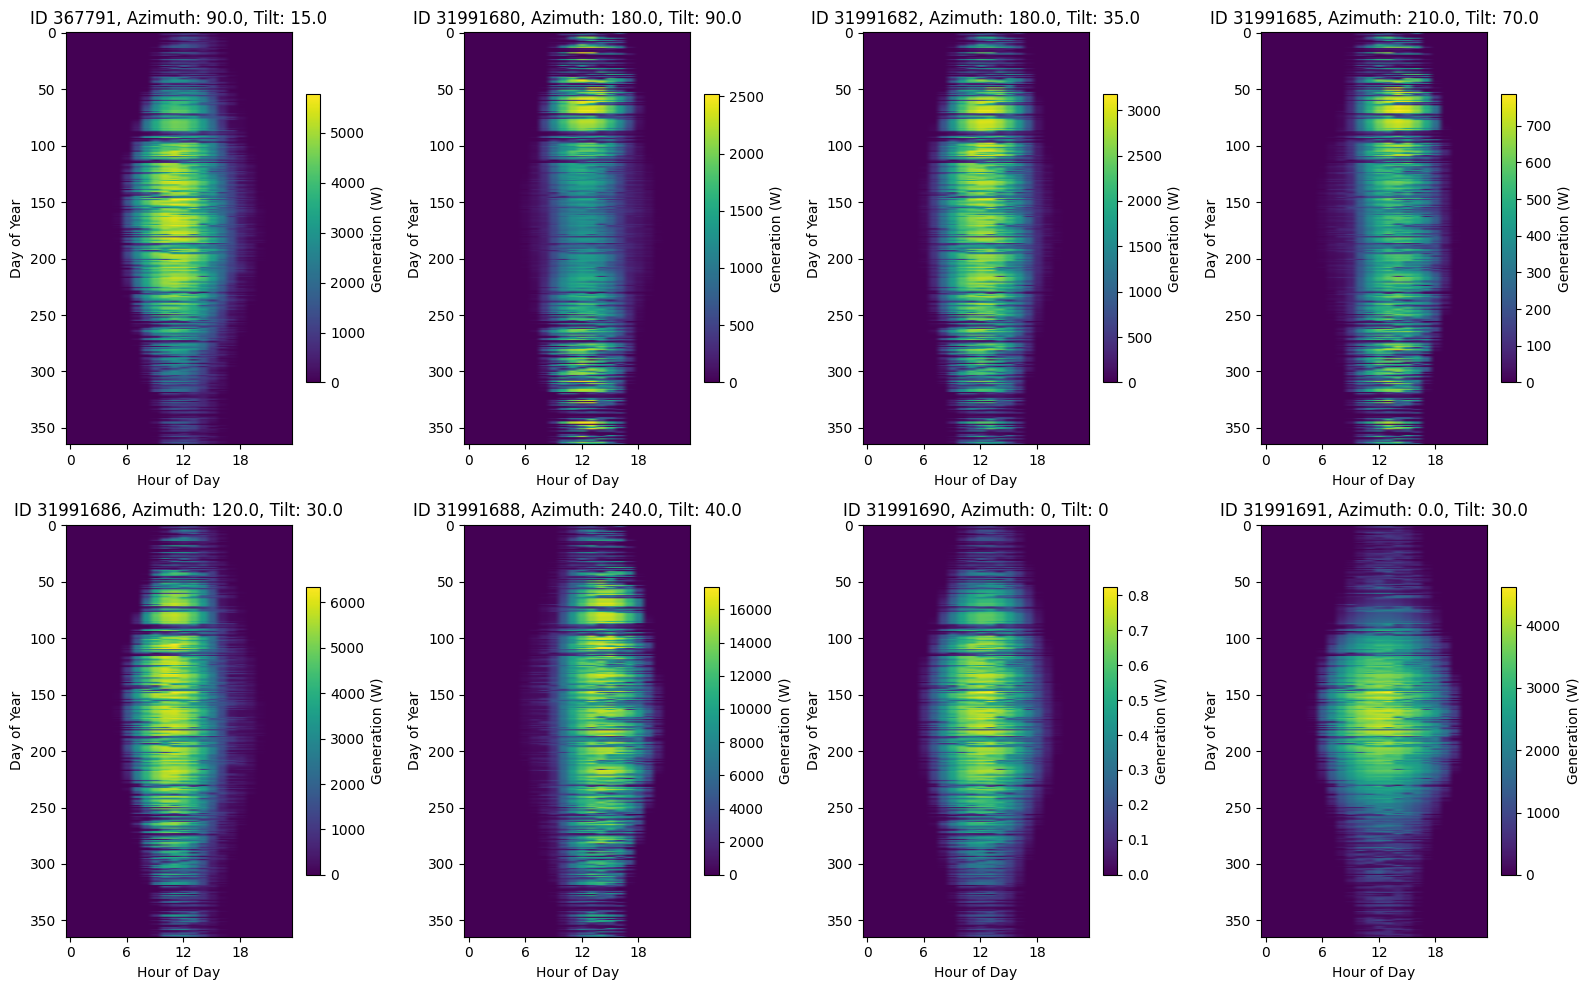

In [11]:
# Figure 5: Heatmap of daily generation patterns
# Create a figure with 8 subfigures (2x4 grid)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# For each PV system, create a separate subplot
for i, obj_id in enumerate(df):
    ts = df[obj_id][Types.PV]

    # Get azimuth and tilt values for the title
    azimuth = system_configs[obj_id]['azimuth'] if obj_id in system_configs else 0
    tilt = system_configs[obj_id]['tilt'] if obj_id in system_configs else 0

    # Create a pivot table with hours as columns and days as rows
    daily_data = ts.copy()
    daily_data.index = pd.MultiIndex.from_arrays([daily_data.index.date, daily_data.index.hour], names=['date', 'hour'])
    daily_pivot = daily_data.unstack(level='hour')

    # Create heatmap
    im = axes[i].imshow(daily_pivot, aspect='auto', cmap='viridis')
    axes[i].set_title(f'ID {obj_id}, Azimuth: {azimuth}, Tilt: {tilt}')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Day of Year')
    axes[i].set_xticks(range(0, 24, 6))  # Show fewer ticks for readability

    # Add colorbar to each subplot
    fig.colorbar(im, ax=axes[i], shrink=0.7, label='Generation (W)')

plt.tight_layout()
plt.show()

## Next Steps
You can further explore:
- Adjusting building parameters in `objects.csv`
- Incorporating or excluding additional data (e.g., internal gains, solar gains)
- Automating analysis for larger building datasets